 # scikit-learn - examples


In [15]:
import pandas as pd
from pathlib import Path

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Load sample datasets

In [46]:
data_dir = Path('data')

df_clf = pd.read_csv(Path(data_dir, 'adult-incomes.csv'))
df_clf_numeric = pd.read_csv(Path(data_dir, 'breast-cancer.csv')).drop('id', axis=1)
df_regression = pd.read_csv(Path(data_dir, 'house_prices.csv')).drop('Id', axis=1)
df_nlp = pd.read_csv(Path(data_dir, 'airline-tweets.csv'))

## Models

### Classifiers

In [9]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=4)

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(n_estimators=200, random_state=0, n_jobs=4)

### Regressors

In [77]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=4)

In [78]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=200, random_state=0, n_jobs=4)

## Preprocessing

### Train/Test split

In [38]:
from sklearn.model_selection import train_test_split

def df_train_test_split(df, label_column, test_size):
    features = df.drop(label_column, axis=1)
    labels = df[label_column]
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=30, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [40]:
x_train, x_test, y_train, y_test = df_train_test_split(df_clf_numeric, 'diagnosis', 0.2)

## Pipelines

### Standardization

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), ('model', RandomForestClassifier())] 

pipeline = Pipeline(steps)
pipeline = pipeline.fit(x_train, y_train)

# | applies same standardization to test set!
y_pred = pipeline.predict(x_test)

### Seperate pipelines for numerical & categorical features

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder


ONE_HOT = True

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

if ONE_HOT:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# | Note: in the following example this will lead o an error, as not all categories from train-set occur in test-set
# | We don't have this issue with OneHotEncoder due to the handle_unknown argument
else:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OrdinalEncoder())])

In [98]:
label_column = 'SalePrice'

numeric_features = df_regression.select_dtypes(exclude=['object']).drop([label_column], axis=1).columns
categorical_features = df_regression.select_dtypes(include=['object']).columns

In [99]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [100]:
steps = [('preprocessor', preprocessor), ('classifier', RandomForestRegressor())]
pipeline = Pipeline(steps)

x_train, x_test, y_train, y_test = df_train_test_split(df_regression, label_column, 0.2)
pipeline = pipeline.fit(x_train, y_train)

# | applies same preprocessing to test set!
y_pred = pipeline.predict(x_test)

Can also apply cross validation with pipelines!

In [101]:
cv = cross_val_score(pipeline, x_train, y_train, cv=3, scoring='r2')
cv

array([0.88161536, 0.85152753, 0.78832593])

## Cross-Validation

### Using functions provided by scikit-learn
List of available metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [123]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=4)

In [125]:
lable_column = 'diagnosis'
x = df_clf_numeric.drop(lable_column, axis=1)
y = df_clf_numeric[lable_column]

<code>cross_val_score</code>

In [126]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(model, x, y, cv=5, scoring='accuracy')
cv

array([0.92982456, 0.94736842, 0.98245614, 0.96491228, 0.97345133])

<code>cross_validate</code>
The main advantage of this function in comparison to cross_val_score is that you can pass a list of multiple evaluation metrics 

In [127]:
from sklearn.model_selection import cross_validate

cv = cross_validate(model, x, y.replace({'B': 0, 'M': 1}), cv=5, scoring=['accuracy', 'precision', 'recall'])

pd.DataFrame(cv)

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,0.196992,0.037998,0.929825,0.906977,0.906977
1,0.178002,0.035998,0.947368,0.974359,0.883721
2,0.175002,0.037998,0.982456,0.976190,0.976190
3,0.192003,0.037998,0.964912,0.975000,0.928571
4,0.179001,0.035998,0.973451,0.953488,0.976190


### Manual Implementation

In [139]:
import sklearn
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from collections import defaultdict


def cross_val(model, x, y, nr_folds=5):
    folds = KFold(n_splits=nr_folds)
    
    scores_dict = defaultdict(list)

    for i, (train_indices, test_indices) in enumerate(folds.split(x)):  
        model = sklearn.base.clone(model)
        
        x_train, x_test = x[train_indices], x[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        
        scores_dict['accuracy'].append(accuracy_score(y_test, y_pred))
        scores_dict['precision'].append(precision_score(y_test, y_pred))
        scores_dict['recall'].append(recall_score(y_test, y_pred))

    return scores_dict

cv = cross_val(model, x.values, y.replace({'B': 0, 'M': 1}).values)

pd.DataFrame(cv)

,accuracy,precision,recall
0,0.912281,0.983333,0.867647
1,0.947368,0.957447,0.918367
2,0.982456,1.000000,0.950000
3,0.956140,0.900000,0.931034
4,0.973451,0.896552,1.000000


## Grid-Search
TODO: Add examples with Optuna: https://github.com/optuna/optuna

### One Model

In [142]:
lable_column = 'diagnosis'
x = df_clf_numeric.drop(lable_column, axis=1)
y = df_clf_numeric[lable_column]

#### XGBoost

In [150]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


param_grid = {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1.5, 4],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 15, 50],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }

model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=0, n_jobs=4)

grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search = grid_search.fit(x, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.6s finished


In [152]:
print('best score: {}\nbest params: {}'.format(grid_search.best_score_, grid_search.best_params_))  

best score: 0.9944761809444088
best params: {'learning_rate': 0.3, 'max_depth': 5}


In [155]:
# Show top-k model configs
df_results = pd.DataFrame(grid_search.cv_results_)
df_results.sort_values(by='rank_test_score', inplace=True)
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.038398,0.001020,0.002402,4.893201e-04,0.3,5,"{'learning_rate': 0.3, 'max_depth': 5}",0.994432,0.988536,1.0,0.989749,0.999665,0.994476,0.004797,1
17,0.040399,0.004079,0.002602,4.907804e-04,0.3,50,"{'learning_rate': 0.3, 'max_depth': 50}",0.994432,0.984605,1.0,0.990741,0.999665,0.993888,0.005781,2
16,0.038598,0.001625,0.002001,3.873843e-07,0.3,15,"{'learning_rate': 0.3, 'max_depth': 15}",0.994432,0.984605,1.0,0.990741,0.999665,0.993888,0.005781,2
12,0.043599,0.001624,0.002401,4.889867e-04,0.2,5,"{'learning_rate': 0.2, 'max_depth': 5}",0.991811,0.986571,1.0,0.989087,0.998659,0.993226,0.005269,4
14,0.046798,0.002485,0.002602,8.002521e-04,0.2,50,"{'learning_rate': 0.2, 'max_depth': 50}",0.991811,0.985588,1.0,0.989418,0.998659,0.993095,0.005480,5


In [165]:
# Select one of the top-k models
k = 2
params_knd_best = df_results.iloc[k-1]['params']
model_knd_best = grid_search.best_estimator_.set_params(**params_2nd_best)

model_knd_best

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

#### Random Forest

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 15],
    'criterion' :['gini', 'entropy']
}

model_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=4)

grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search = grid_search.fit(x, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   11.3s finished


In [169]:
print('best score: {}\nbest params: {}'.format(grid_search.best_score_, grid_search.best_params_))  

best score: 0.9920393809887751
best params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}



You can also pass a list of dictionaries as param_grid, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.

This makes sense e.g. when some parameter configurations are not valid (e.g. 'sag' & 'l1' for LogisticRegression()):

```python
param_grid = [
    {'classifier__penalty' : ['l1'],
    'classifier__C' : np.logspace(-4, 4, 10),
    'classifier__solver' : ['liblinear', 'saga']},
    
    {'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 10),
    'classifier__solver' : ['lbfgs', 'liblinear', 'sag', 'saga']}
]
```

### Multiple Models

In [206]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

steps = [('classifier' , LogisticRegression())]
pipeline = Pipeline(steps)

In [207]:
param_grid = [    
    {'classifier' : [LogisticRegression()],
    'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 10),
    'classifier__solver' : ['lbfgs', 'liblinear', 'sag', 'saga']},
    
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(50,101,10)),
    'classifier__max_features' : ['auto', 'log2'],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__oob_score' : [True, False]},

    {'classifier' : [KNeighborsClassifier()],
    'classifier_n_neighbors': np.arange(3, 15),
    'classifier_weights': ['uniform', 'distance'],
    'classifier_algorithm': ['ball_tree', 'kd_tree', 'brute']}
]

In [ ]:
x, y = make_classification(n_samples=100, n_features=15, n_redundant=0, n_informative=15, n_clusters_per_class=1,
                           random_state=0, shuffle=False, n_classes=2)

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search = grid_search.fit(x, y)

### TF-IDF NLP Pipeline

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Gridsearch/CV with preprocessing
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier' , RandomForestClassifier())])

param_grid = [
    {'classifier__max_depth' : [5, 10, 15],
    'classifier__criterion' : ['gini', 'entropy'],
     
    'vectorizer__sublinear_tf' : [True, False],
    'vectorizer__ngram_range' : [(1, 1), (1, 2)],
    'vectorizer__min_df' : [1, 2, 3],
    'vectorizer__strip_accents' : ['unicode'],
    'vectorizer__max_features' : [5000, 10000],
    'vectorizer__stop_words' : [None, 'english']}
]

grid_search = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, scoring='accuracy', n_jobs=-1)
grid_search = grid_search.fit(df_nlp['text'], df_nlp['airline_sentiment'].astype('category').cat.codes)

print('best score: {}\nbest params: {}'.format(best_clf.best_score_, best_clf.best_params_))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.8s


## Evaluation

### Confusion Matrix

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

nr_classes = 5
x, y = make_classification(n_samples=1000, n_features=15, n_redundant=0, n_informative=15, n_clusters_per_class=1,
                           random_state=0, shuffle=False, n_classes=nr_classes)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30, shuffle=True)

model = RandomForestClassifier(max_depth=2, random_state=0)
model = model.fit(x_train, y_train)

y_pred = model.predict(x_test)

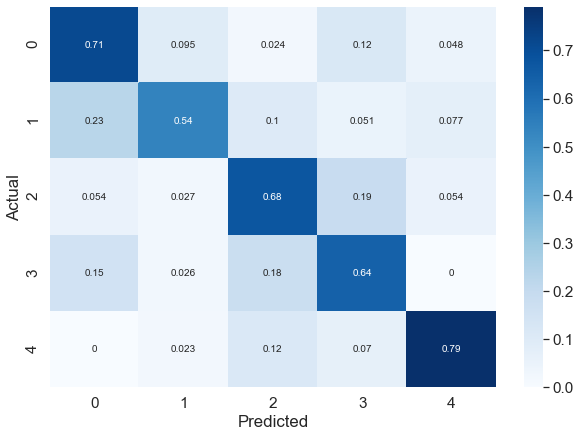

In [198]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

categories = np.unique(y_train)

cm = confusion_matrix(y_test, y_pred, labels=categories, normalize='true')
df_cm = pd.DataFrame(cm, columns=categories, index = categories)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 10})# font size